# Training/Test split
- Create $N-1$ equidistant splits where $N$ is the number of covered years
- For each split normalize the distributions and compute the KL divergence between the training and test set
- Finally, compute the maximum KL divergence and plot both the histograms 

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [105]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [106]:
fsd = "first_submission_date"

In [107]:
# Convert the date to datetime
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

In [108]:
fsd = "first_submission_date"

# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

# Create equidistant splits
date_splits = [pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}") +
               pd.Timedelta(i * (date_max - date_min).days / (date_max.year - date_min.year), unit='D')
               for i in range(1, date_max.year - date_min.year)]
date_splits

[Timestamp('2007-05-18 00:00:00'),
 Timestamp('2008-05-13 00:00:00'),
 Timestamp('2009-05-09 00:00:00'),
 Timestamp('2010-05-05 00:00:00'),
 Timestamp('2011-05-01 00:00:00'),
 Timestamp('2012-04-26 00:00:00'),
 Timestamp('2013-04-22 00:00:00'),
 Timestamp('2014-04-18 00:00:00'),
 Timestamp('2015-04-14 00:00:00'),
 Timestamp('2016-04-09 00:00:00'),
 Timestamp('2017-04-05 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2019-03-28 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2021-03-19 00:00:00')]

In [109]:
def split_and_normalize(src_df: pd.DataFrame, split_condition: bool, split_label: str = ""):
    dst_df = src_df[split_condition]
    dst_df = dst_df.groupby(["family"]).size().reset_index(name='count')
    dst_df["perc"] = dst_df["count"] / dst_df["count"].sum()
    dst_df["split"] = split_label
    return dst_df


def kl_divergence(p, q):
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-7
    p = np.clip(p, epsilon, 1 - epsilon)
    q = np.clip(q, epsilon, 1 - epsilon)
    return np.sum(p * np.log(p / q))

In [110]:
# Compute the KL divergence for each possible split
df_split = df_dt.copy()
kl_divergences = []
for date_split in date_splits:
    # Split the dataset
    df_train = split_and_normalize(df_split, df_split[fsd] < date_split)
    df_test = split_and_normalize(df_split, df_split[fsd] >= date_split)
    kl_divergences.append(kl_divergence(df_train["perc"], df_test["perc"]))

Max KL divergence: 3.232605883830189, Best split: 2007-05-18 00:00:00


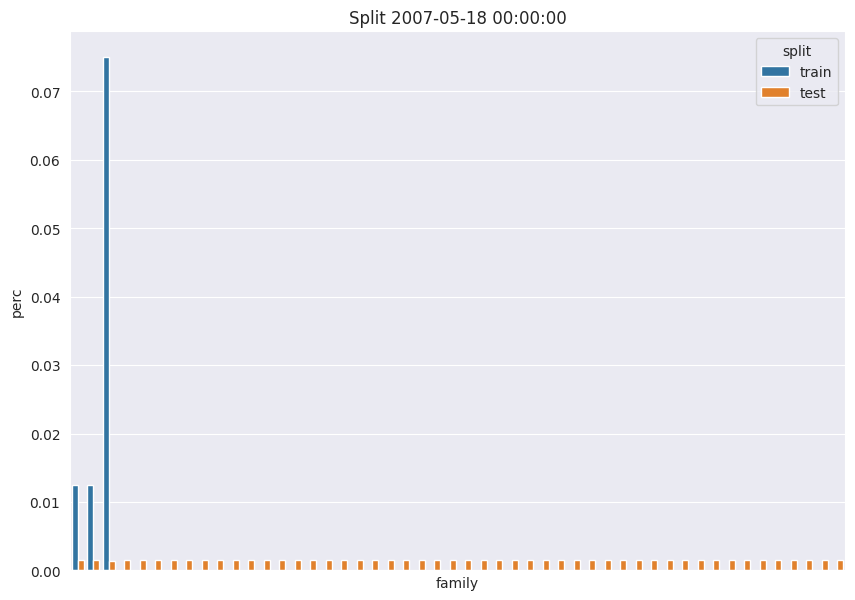

In [114]:
# Get the maximum KL divergence and plot the histogram
max_idx, max_kl = np.argmax(kl_divergences), np.max(kl_divergences)
best_split = date_splits[max_idx]

print(f"Max KL divergence: {max_kl}, Best split: {best_split}")

# Split the dataset
df_train = split_and_normalize(df_split, df_split[fsd] < best_split, "train")
df_test = split_and_normalize(df_split, df_split[fsd] >= best_split, "test")

# Take only 50 families for visualization purposes
families = df["family"].unique()[:50]

# df_train = df_train.sort_values(by="perc", ascending=False)
# top_df_train_families = df_train["family"]#[:50]
# 
df_train = df_train[df_train["family"].isin(families)]
df_test = df_test[df_test["family"].isin(families)]

df_merge = pd.concat([df_train, df_test])
plt.figure(figsize=(10, 7))
plt.title(f"Split {best_split}")
sns.barplot(data=df_merge, x="family", y="perc", hue="split")
plt.xticks([])
plt.show()